# UES Algorithm

This Notebook focuses on the re-implementation of the UES query plan optimization algorithm.

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import collections
import json

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

from transform import db, mosp, ues, util

In [4]:
with open("../simplicity-done-right/JOB-Queries/implicit/19c.sql", "r") as query_file:
    example_query = " ".join(line.strip() for line in query_file.readlines())
q = mosp.MospQuery.parse(example_query)
example_query

"SELECT COUNT(*) FROM aka_name AS an, char_name AS chn, cast_info AS ci, company_name AS cn, info_type AS it, movie_companies AS mc, movie_info AS mi, name AS n, role_type AS rt, title AS t WHERE ci.note IN ('(voice)', '(voice: Japanese version)', '(voice) (uncredited)', '(voice: English version)') AND cn.country_code ='[us]' AND it.info = 'release dates' AND mi.info IS NOT NULL AND (mi.info LIKE 'Japan:%200%' OR mi.info LIKE 'USA:%200%') AND n.gender ='f' AND n.name LIKE '%An%' AND rt.role ='actress' AND t.production_year > 2000 AND t.id = mi.movie_id AND t.id = mc.movie_id AND t.id = ci.movie_id AND mc.movie_id = ci.movie_id AND mc.movie_id = mi.movie_id AND mi.movie_id = ci.movie_id AND cn.id = mc.company_id AND it.id = mi.info_type_id AND n.id = ci.person_id AND rt.id = ci.role_id AND n.id = an.person_id AND ci.person_id = an.person_id AND chn.id = ci.person_role_id; "

In [18]:
predicate_map = ues._build_predicate_map(q)

Selected first table: movie_info AS mi
Selected next table: cast_info AS ci with PK joins [role_type AS rt, name AS n, char_name AS chn]
Selected next table: movie_companies AS mc with PK joins [company_name AS cn]
Selected next table: aka_name AS an with PK joins []


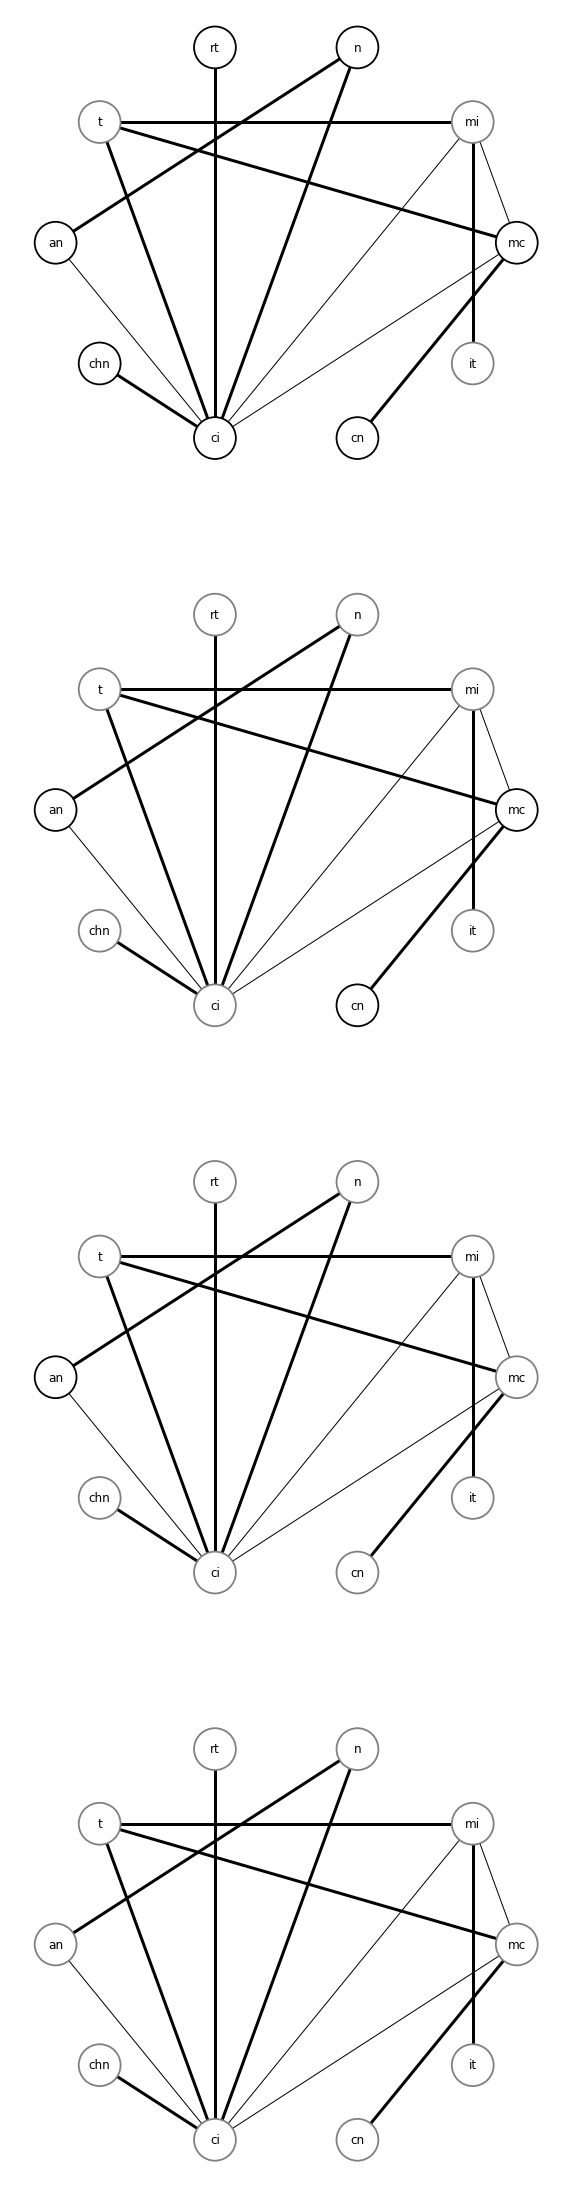

In [24]:
join_order = ues._calculate_join_order(q, predicate_map=predicate_map)

In [25]:
join_order

movie_info ⋈ info_type [it.id = mi.info_type_id] ⋈ title [t.id = mi.movie_id] ⋈ cast_info [t.id = ci.movie_id] ⋈ role_type [rt.id = ci.role_id] ⋈ name [n.id = ci.person_id] ⋈ char_name [chn.id = ci.person_role_id] ⋈ movie_companies [mc.movie_id = ci.movie_id] ⋈ company_name [cn.id = mc.company_id] ⋈ aka_name [n.id = an.person_id]

In [15]:
join_order.traverse_right_deep()

[{'subquery': False, 'table': movie_info AS mi},
 {'subquery': False, 'table': info_type AS it},
 {'subquery': False, 'table': title AS t},
 {'subquery': False, 'table': cast_info AS ci},
 {'subquery': False, 'table': role_type AS rt},
 {'subquery': False, 'table': name AS n},
 {'subquery': False, 'table': char_name AS chn},
 {'subquery': False, 'table': movie_companies AS mc},
 {'subquery': False, 'table': company_name AS cn},
 {'subquery': False, 'table': aka_name AS an}]

In [17]:
ues.JoinTree.load_from_query(q_ues)

movie_info ⋈ info_type ⋈ title ⋈ movie_companies ⋈ company_name ⋈ cast_info ⋈ role_type ⋈ char_name ⋈ aka_name ⋈ name

In [5]:
dbs = db.DBSchema.get_instance()

In [6]:
with open("../simplicity-done-right/JOB-Queries/explicit/19c.sql", "r") as query_file:
    example_ues = " ".join(line.strip() for line in query_file.readlines())
q_ues = mosp.MospQuery.parse(example_ues)
example_ues

"select count(*) from movie_info AS mi join info_type AS it on (it.info = 'release dates' AND it.id = mi.info_type_id and mi.info IS NOT NULL AND (mi.info LIKE 'Japan:%200%' OR mi.info LIKE 'USA:%200%')) join title AS t on (t.production_year > 2000 AND t.id = mi.movie_id) JOIN movie_companies AS mc on(mc.movie_id = mi.movie_id) join company_name AS cn on (cn.country_code ='[us]' AND cn.id = mc.company_id) JOIN cast_info AS ci on(ci.movie_id = mc.movie_id and ci.note IN ('(voice)', '(voice: Japanese version)', '(voice) (uncredited)', '(voice: English version)')) join role_type AS rt on (rt.role ='actress' AND rt.id = ci.role_id) join char_name AS chn on (chn.id = ci.person_role_id) JOIN aka_name AS an on(an.person_id = ci.person_id) join name AS n on (n.gender ='f' AND n.name LIKE '%An%' AND n.id = an.person_id);"

---

## Inspection

In [8]:
graph = ues._JoinGraph.build_for(q)
g = graph.graph

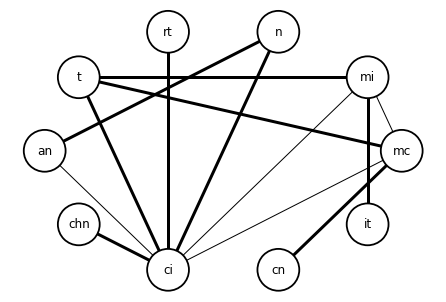

In [9]:
graph.print()

In [10]:
t1, t2 = list(g.nodes)[:2]
t1, t2

(aka_name AS an, char_name AS chn)

In [11]:
for n, d in g.adj[t1].items():
    print(n, "||", d)

name AS n || {'pk_fk_join': True, 'predicate': [n.id = an.person_id], 'primary_key': n.id, 'foreign_key': an.person_id}
cast_info AS ci || {'pk_fk_join': False, 'predicate': [ci.person_id = an.person_id], 'primary_key': None, 'foreign_key': None}
